# ARIMA Time Series Analysis

In [1]:
import pandas as pd
import numpy as np

from src.util.FunctionExecTime import time_runtime

## Prepare the data

This competition is not intended to be a forecasting problem.
The prediction to be made is about how many of given items are
sold in a given shop.
The test set contains 5100 items and 42 shops. Thus, the total entries
to be predicted sums up to 5100 * 42 = 214'200 predictions.
Not very suiting for ARIMA.

Therefore, we have to transform the cross-sectional data into a time series.
First, we are going to throw away all data from shops and items that are
present in the train data, but not in the test data.
Then, we are going to regroup the total sales of single items on a given day.
Finally, the shop information is thrown away. With ARIMA being a univariate
forecasting method, the item price is irrelevant as well.


In [2]:
# set to `True` if the data needs to be generated first.
prepare_data = False

### Clean irrelevant data

This took about half an hour to run.

In [3]:
def clean_data():
    train = pd.read_csv('data/technical/sales_train.csv')
    test = pd.read_csv('data/technical/test.csv')

    # begin by preparing data

    # begin by clipping as the competition states
    train['item_cnt_day'] = train['item_cnt_day'].clip(0, 20)

    # first, throw away the data from irrelevant shops

    shops_in_test_set = set()
    for index, row in test.iterrows():
        shops_in_test_set.add(row['shop_id'])

    all_shops = set([*range(0, 60)])
    shops_missing = all_shops - shops_in_test_set

    for shop_missing in shops_missing:
        index_names = train[ train['shop_id'] == shop_missing].index
        train.drop(index_names, inplace=True)

    # throw away the data from irrelevant items

    items_in_test_set = set()
    for index, row in test.iterrows():
        items_in_test_set.add(row['item_id'])

    items_in_train_set = set()
    for index,row in train.iterrows():
        items_in_train_set.add(row['item_id'])

    items_missing = items_in_train_set - items_in_test_set

    for item_missing in items_missing:
        train.drop(train[train['item_id'] == item_missing].index, inplace=True)

    # remove the month sales as we are not going to account for this in the ARIMA forecast
    train.drop(['date_block_num', 'shop_id', 'item_price'], axis=1, inplace=True)

    # export items
    train.to_csv('data/arima/train_cleaned.csv', index=False)

if prepare_data:
    time_runtime(clean_data)

Runtime of function "clean_data": 26min & 18s


### Select item to be forecasted

We are now going to determine the most prominent item in the dataset.
Thankfully, this is a lot quicker. Takes about half a minute.

In [4]:
def select_item_for_forecast():
    train = pd.read_csv('data/arima/train_cleaned.csv')

    # to check for errors: print amount of dates in total available in the dataset
    all_dates = set()
    for index, row in train.iterrows():
        all_dates.add(row['date'])
    len(all_dates)


    train = train.groupby(['date', 'item_id']).sum('item_cnt_day').reset_index()

    all_items = set()
    for index,row in train.iterrows():
        all_items.add(row['item_id'])

    date_sequences_all_items = []

    for item in all_items:

        df_this_item = train[train.item_id == item]

        date_sequences_all_items.append(
            (item, df_this_item)
        )

    for sequence in date_sequences_all_items:
        if sequence[1].shape[0] > 1000:
            print(f"Item ID: {sequence[0]}\nData present for {sequence[1].shape[0]} days.")

    # allocate a new df to the most prominent item
    df = train[train.item_id == 5822].copy()
    df.drop('item_id', axis=1, inplace=True)

    # insert zero-sales for the days that are missing in the item series.
    all_dates_in_dataset = set()
    for _, row in df.iterrows():
        all_dates_in_dataset.add(row['date'])

    # dates without sales are: 06.02.20112 & 11.02.2013
    dates_in_dataset_missing = all_dates - all_dates_in_dataset

    for date in dates_in_dataset_missing:
        new_row = pd.DataFrame({'date': [date], 'item_cnt_day': [0.0]})
        df = df.append(new_row)

    # format the table
    df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.date
    df.sort_values(by='date', inplace=True)
    df.set_index('date', drop=True, inplace=True)

    df.to_csv('data/arima/inspect_this_item.csv')

if prepare_data:
    time_runtime(select_item_for_forecast)

Item ID: 2308
Data present for 1014 days.
Item ID: 5822
Data present for 1032 days.
Runtime of function "select_item_for_forecast": 51s


## Analyze timeseries

### Preparation

#### Read the data and set the corresponding datatype.

In [5]:
df = pd.read_csv('data/arima/inspect_this_item.csv')
# convert the date to datetime object and set a DatetimeIndex
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
# assign the correct datatype and rename the column
df['item_cnt_day'] = df['item_cnt_day'].astype(np.int16)
df.rename(columns={'item_cnt_day': 'sales'}, inplace=True)

#### Define a function to compare the Root Mean Squared Error score across the project

In [6]:
from sklearn.metrics import mean_squared_error
def rmse():
    return np.sqrt(mean_squared_error(df['sales'], results_ARIMA.fittedvalues))

#### Import plotting library

In [7]:
# set matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting.Defaults import hka_red, iwi_purple, set_defaults
%matplotlib inline
set_defaults()

label_sales_unit = "Items sold (pieces)"
label_period = "Period"

### Domain knowledge

Having information about the inspected items in a time series helps a lot to understand
the problem. This helps us in regards to seasonal and trending inclinations as well as interpreting
outliers and detecting potential issues with the data.

The item inspected here is "Playstation Store пополнение бумажника: Карта оплаты 1000 руб.". This translates to
"Playstation Store wallet replenishment: Payment card 1000 rubles.".

With the Playstation store being launched in 2006 and being a popular choice for console gamers, we expect
no particular trends or seasonality in the data.


### Distribution

To start off, get a feel for the distribution of the sales data.

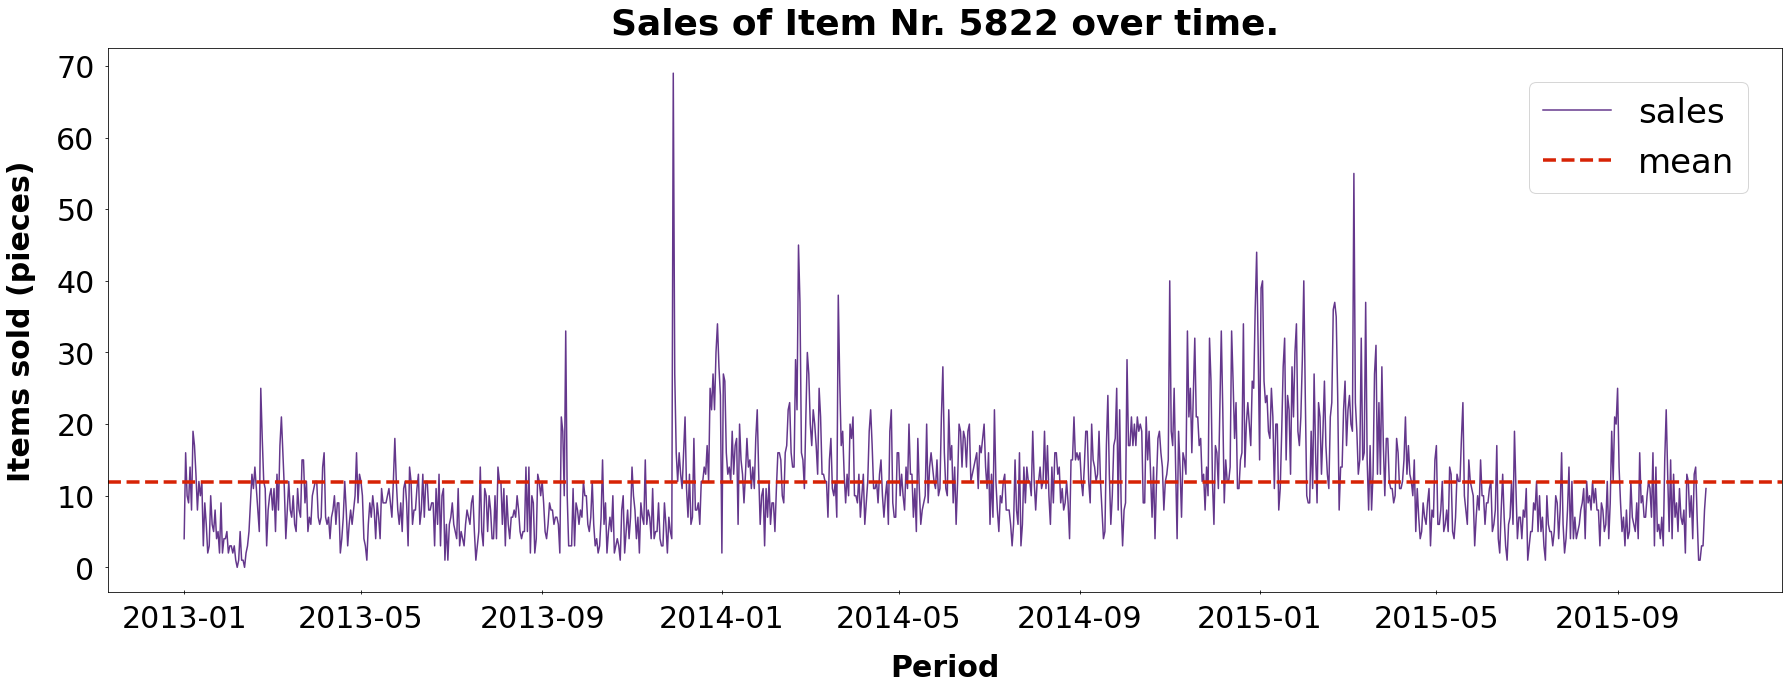

In [8]:
# plot the time series
plt.plot(df['date'], df['sales'], label='sales', color=iwi_purple, marker='')
mean = df['sales'].mean()
plt.axhline(mean, color=hka_red, linewidth=3.5, label='mean', linestyle='dashed')
plt.xlabel(label_period)
plt.ylabel(label_sales_unit)
plt.title("Sales of Item Nr. 5822 over time.")
plt.legend()

### Trend

The previous distribution indicates that no trend is present in the data.
Let us verify this by calculating the trend coefficient using a linear regression.

In [9]:
from sklearn.linear_model import LinearRegression

trend = LinearRegression(normalize=True)
trend.fit(np.array(df['date'].apply(lambda x: x.toordinal())).reshape(-1, 1), df['sales'])
print(f'Trend coefficient: {trend.coef_[0]}')

del trend, LinearRegression

Trend coefficient: 0.004633976431449815


The low trend coefficient confirms that there is no trend in the data.

### Seasonality

Same as the trend, the distribution suggests that there is no seasonality in the model.
Let's verify that.

In [10]:
inspect_quarter = df.copy()
# create a new dataframe and add a quarter column
inspect_quarter["quarter"] = df.date.dt.quarter

# drop the months where the quarter is not present in total to avoid to forge the mean quarter sales
drop_incomplete_quarter = inspect_quarter[(inspect_quarter['date'].dt.year == 2015) & (inspect_quarter['date'].dt.month == 10)].index
inspect_quarter.drop(drop_incomplete_quarter, inplace=True)
inspect_quarter.drop('date', axis=1, inplace=True)
del drop_incomplete_quarter

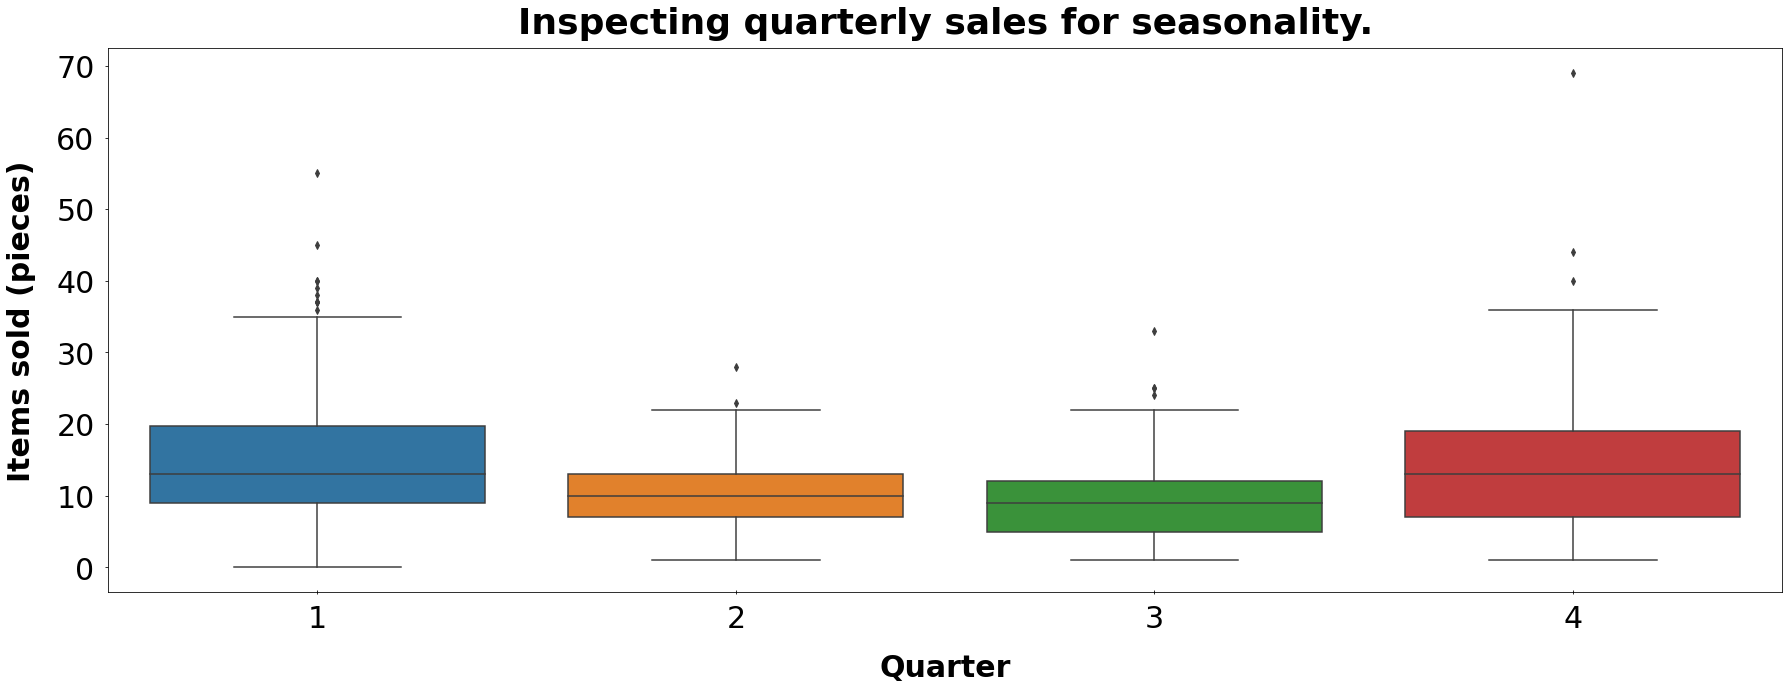

In [11]:
sns.boxplot(data=inspect_quarter, x='quarter', y='sales')
sns.set_palette('colorblind')
plt.title("Inspecting quarterly sales for seasonality.")
plt.xlabel("Quarter")
plt.ylabel(label_sales_unit)
del inspect_quarter

The seasonality seems to be slightly inclined towards the first and last quarter of the year.
The relevance on the full effect on stationarity will be examined in detail later on with the
Augmented Dickey Fuller (ADF) test.

### Preliminary ARIMA application

##### Transform Index to DatetimeIndex

In [12]:
df.set_index('date', drop=True, inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('d')

##### Apply ARIMA

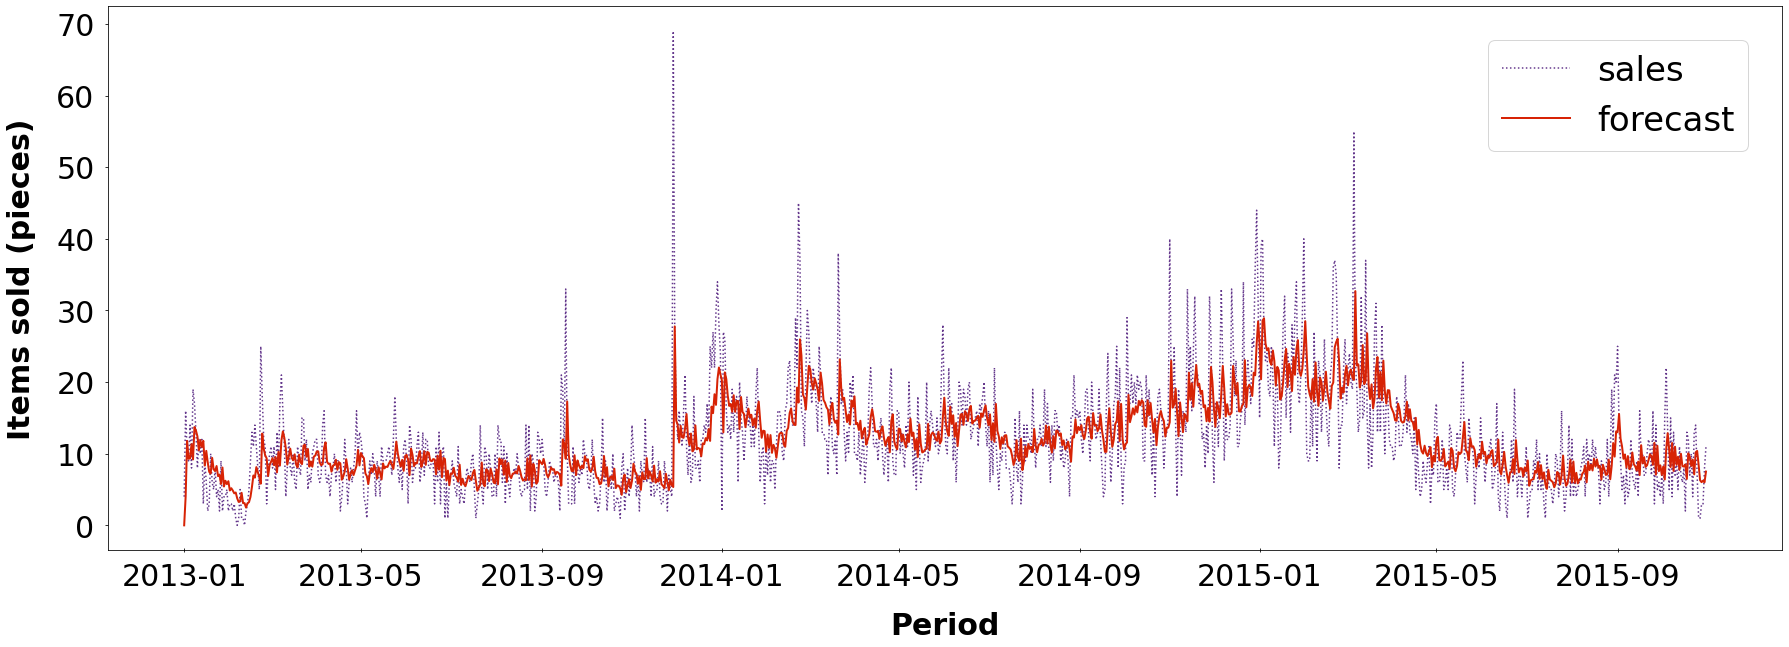

In [13]:
from statsmodels.tsa.arima.model import ARIMA

def apply_arima(p, d, q):
    model = ARIMA(df, order=(p, d, q))
    return model.fit()

def apply_and_plot_arima(p, d, q):
    results = apply_arima(p, d, q)
    plt.plot_date(df.index, df['sales'], fmt=":", label='sales', color=iwi_purple)
    plt.plot(results.fittedvalues, color=hka_red, label='forecast', linewidth=2)
    plt.xlabel(label_period)
    plt.ylabel(label_sales_unit)
    plt.legend()
    return results

results_ARIMA = apply_and_plot_arima(2,1,2)

In [14]:
# inspect the RMSE analog to the linear regression data
rmse()

5.855317761125663

## Understand ARIMA

The source for this information has been taken from the following course
["Stat 510"](https://online.stat.psu.edu/stat510/) from PennState Eberly College of Science.

ARIMA is an acronym that is divided into three parts:
+ `AR` stands for "Auto-Regressive". It is expressed in the parameter `p`.
AR tries to predict the delta of its next entry in the time series.
The Partial AutoCorrelation Function (PACF) plot is used to estimate the best suited value.
+ `I` stands for "Integrated". It is expressed in the parameter `d`.
The `I` parameter is determined using the Augmented Dickey Fuller (ADF) test.
+ `MA` stands for "Moving-Average". It is expressed in the parameter `q`.
`MA` attempts to account for a change in seasonality in the data.
The AutoCorrelation Function (ACF) plot is used to estimate the best suited value.

### Determine d

In [15]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller Test:')
adf = adfuller(df['sales'], autolag='AIC')

adf_result = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf[4].items():
    adf_result[f'Critical Value {key}'] = value

print(adf_result)

del adf, adf_result, key, value

Results of Dickey Fuller Test:
Test Statistic                   -3.478252
p-value                           0.008564
#Lags Used                       15.000000
Number of Observations Used    1018.000000
Critical Value 1%                -3.436790
Critical Value 5%                -2.864383
Critical Value 10%               -2.568284
dtype: float64


With a `p` value close to 0 (below 0.05) and the critical values being
close to the test statistic, the model does appear to require any differencing.
The data is therefore stationary as the first graph of the timeseries
suggests as no seasonality can be observed.

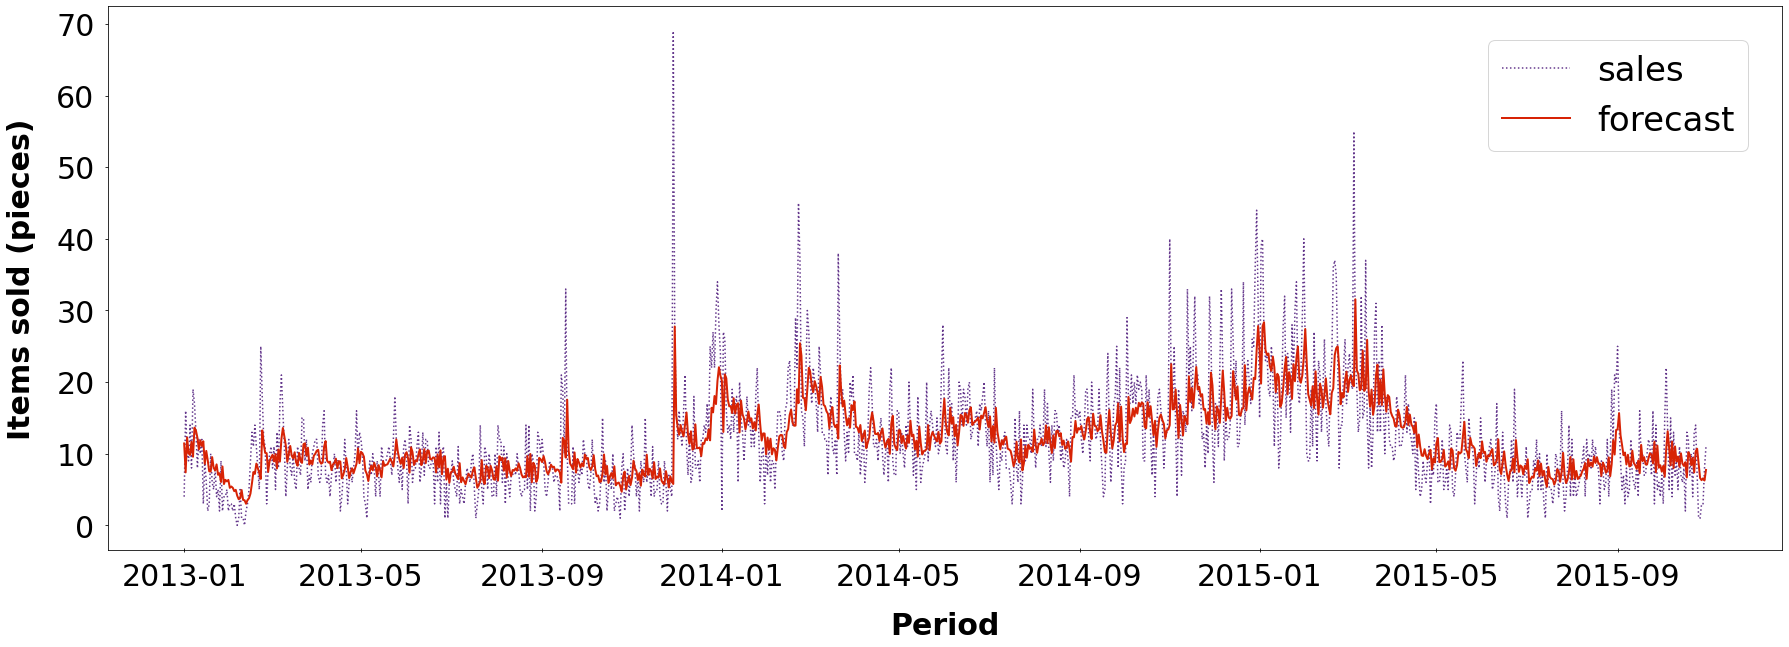

In [16]:
results_ARIMA = apply_and_plot_arima(2, 0, 2)

In [17]:
rmse()

5.841710585532905

### Determine q

The parameter `q` denotes the Auto-Regressive (AR) part of the model. This coefficient
attempts to capture the average discrepancy between the single steps in the considered
time period.

To determine the coefficient, we are going to look at the PACF plot and identify the
correlations between the lags before the series converges to a mean value.

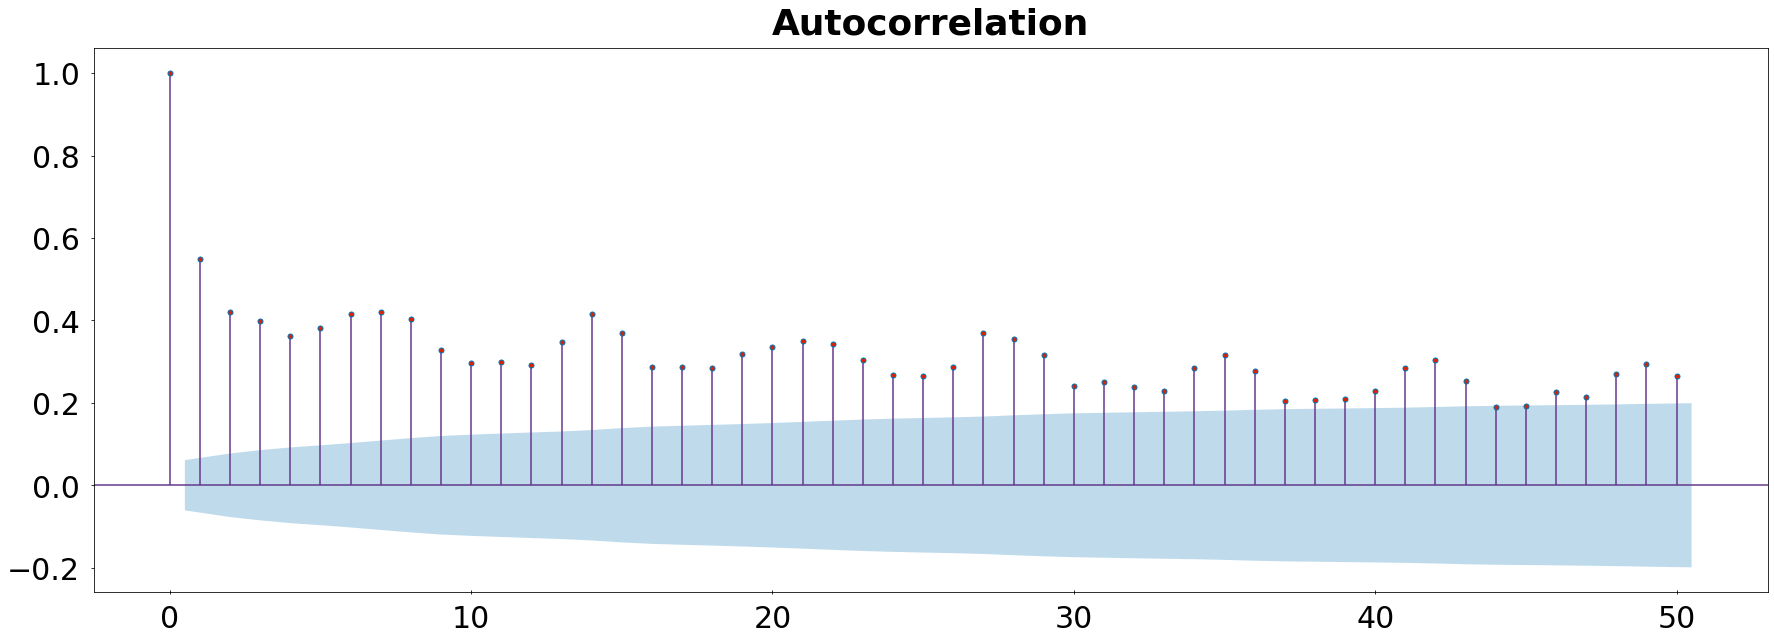

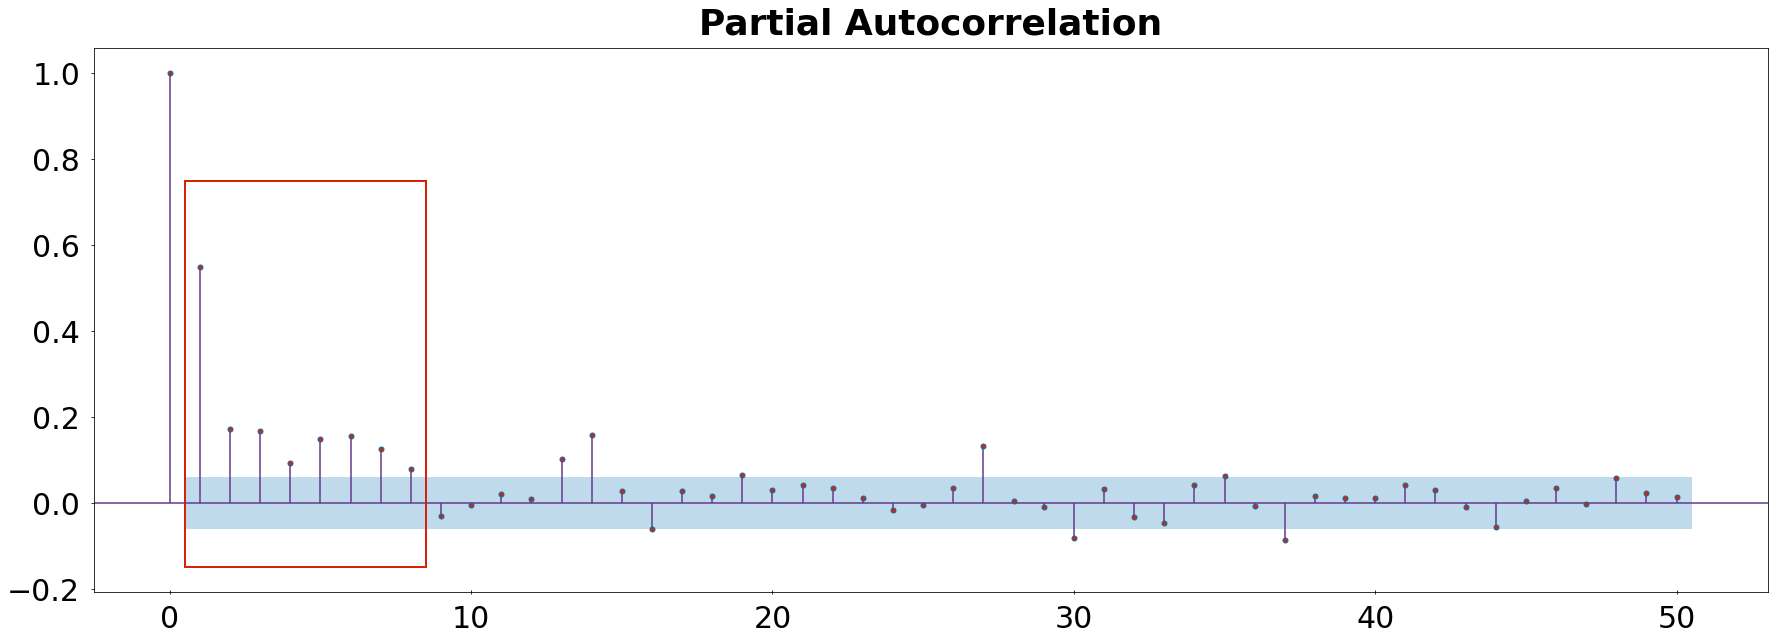

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df, lags = 50)
plot_pacf(df, lags = 50)
highlight = plt.Rectangle((0.5,-0.15), 8, 0.9, edgecolor=hka_red, fill=False, linewidth=2)
plt.gca().add_patch(highlight)

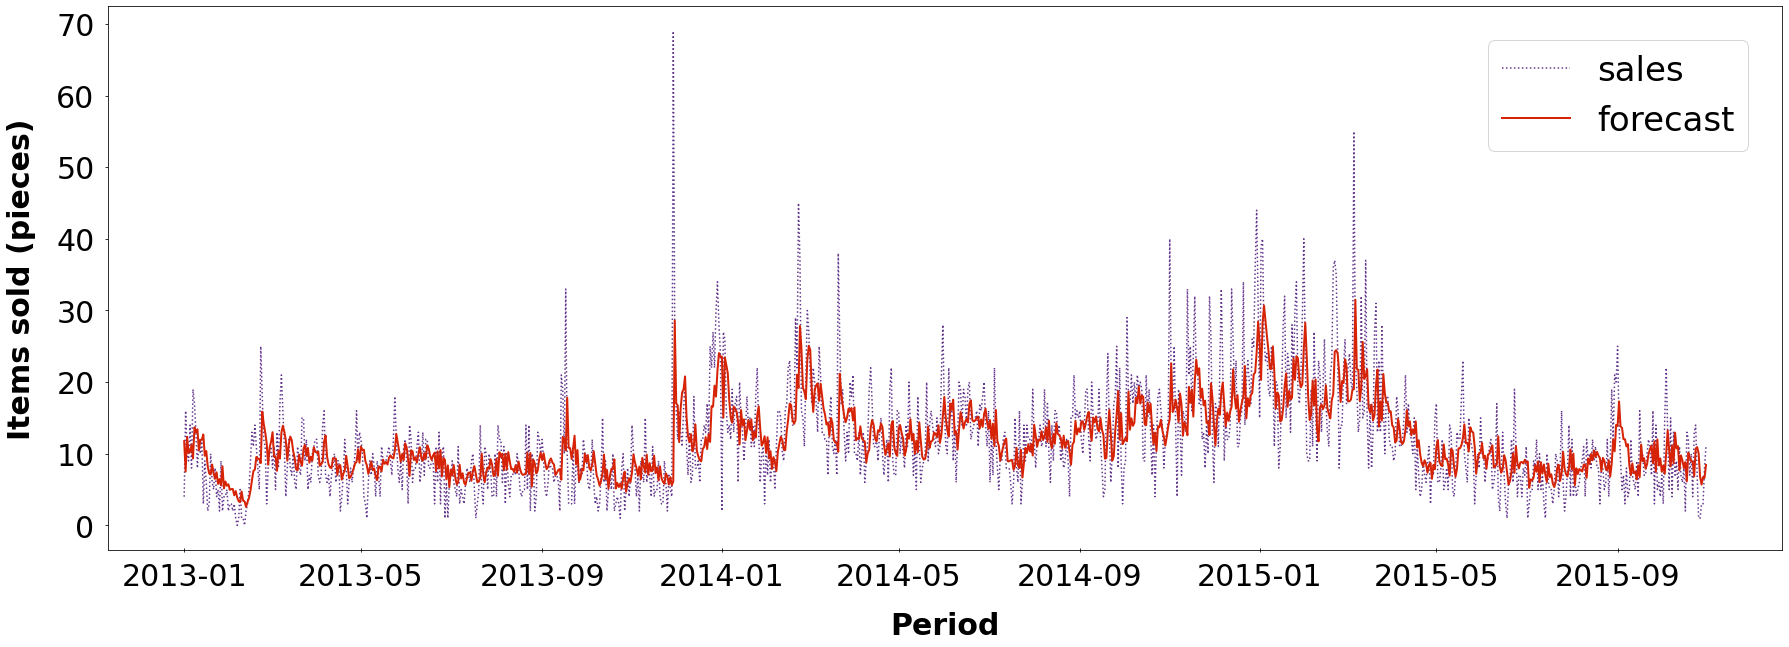

In [19]:
results_ARIMA = apply_and_plot_arima(8, 0, 2)

In [20]:
rmse()

5.8316346841004645

### Determine p

The parameter `p` denotes the Moving-Average (MA) part of the model. This coefficient
attempts to capture the average discrepancy between the single steps in the considered
time period.
To determine this value, read count the amount of lags before the remaining of the series
falls into a set pattern with a varying amplitude.

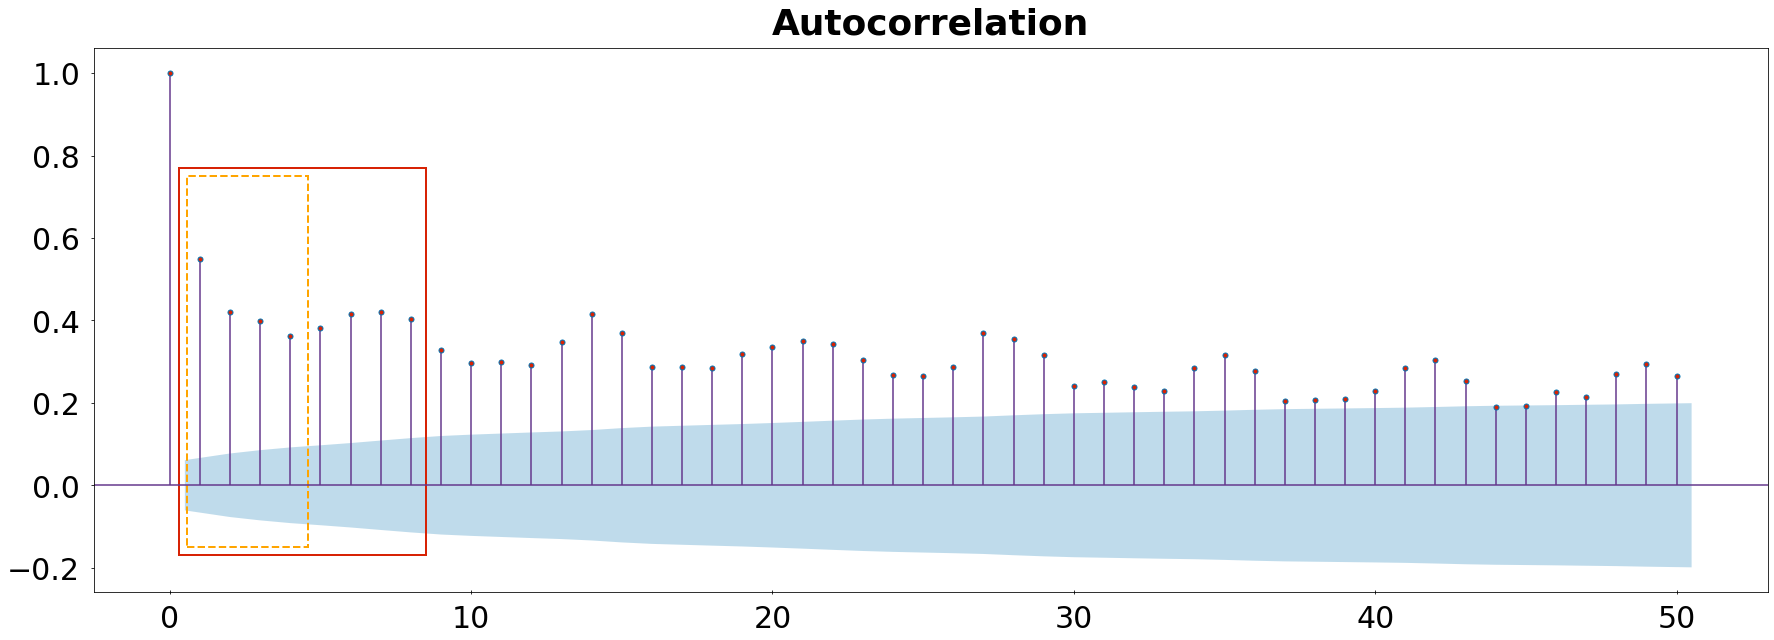

In [21]:
plot_acf(df, lags = 50)
highlight = plt.Rectangle((0.58,-0.15), 4, 0.9, edgecolor='orange', fill=False, linewidth=2, linestyle='dashed')
highlight2 = plt.Rectangle((0.3,-0.17), 8.2, 0.94, edgecolor=hka_red, fill=False, linewidth=2)
plt.gca().add_patch(highlight)
plt.gca().add_patch(highlight2)

del highlight, highlight2

As the pattern is not clearly delimited in this graph, attempt the 4th or the 8th lag.

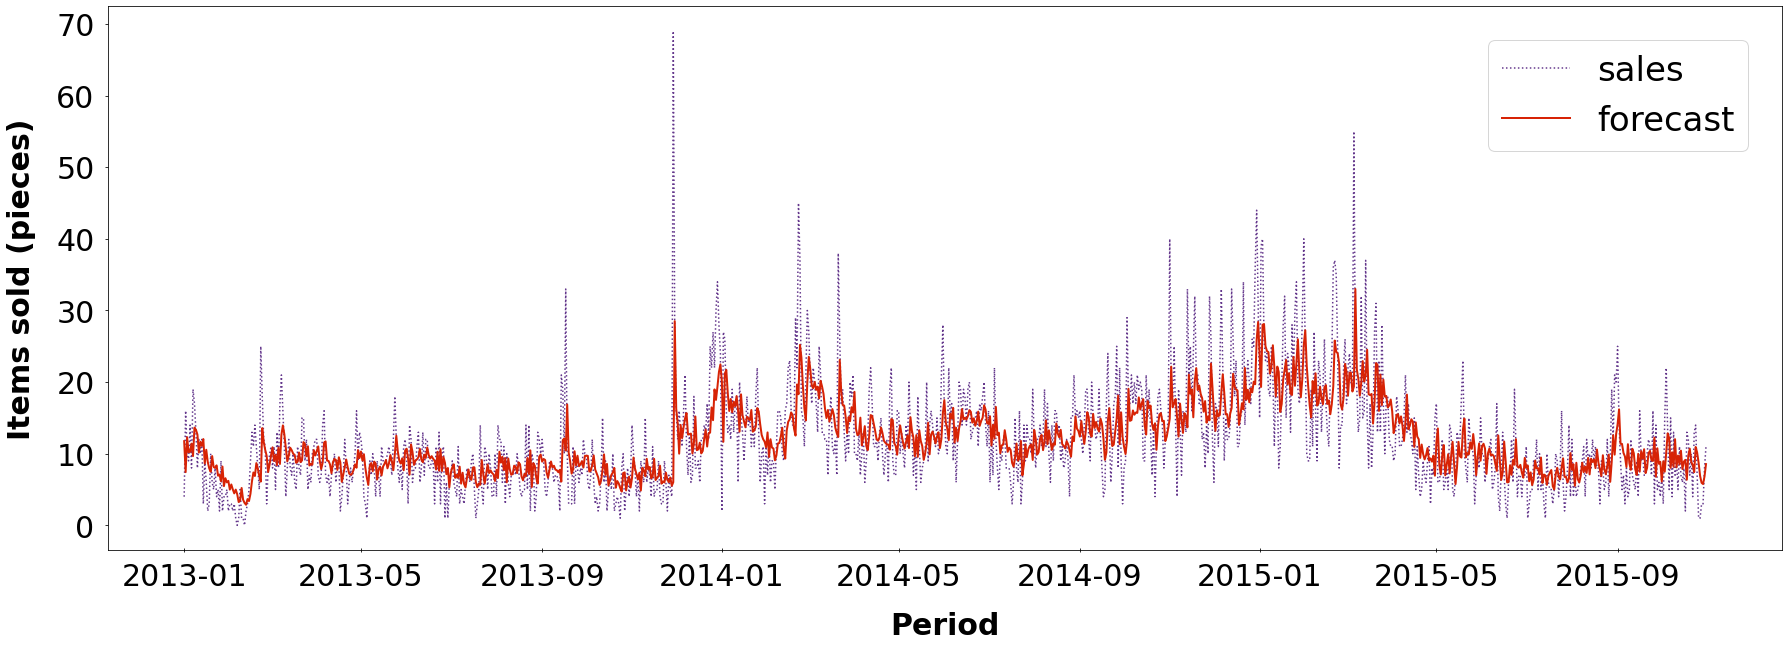

In [22]:
results_ARIMA = apply_and_plot_arima(8, 0, 4)

In [23]:
rmse()

5.782391877138444

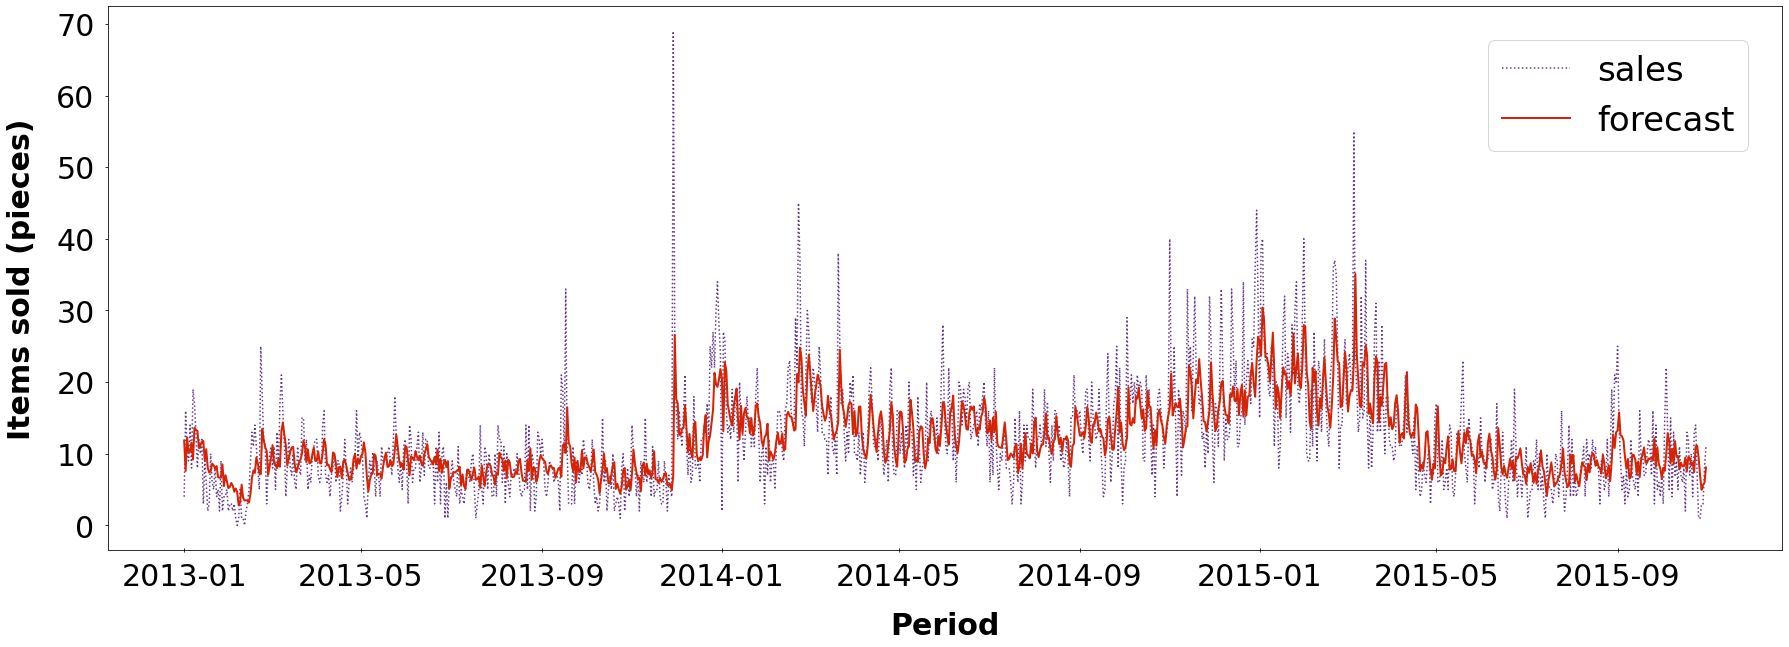

In [24]:
results_ARIMA = apply_and_plot_arima(8, 0, 8)

In [25]:
rmse()

5.6416007653655

### Proof of concept

Brute force the best ARIMA parameters for trial and error. This is rarely a feasible solution
as the model, in this case, has to do a total of 10x3x10 = 300 predictions.

This works on this relatively small dataset, albeit still taking a long while to process.

In [26]:
# set to `True` if the ARIMA proof of concept should be rerun.
run_arima_proof_of_concept = False

Create the list of possible tuples

In [27]:
from itertools import product
ps = [*range(10)]
ds = [*range(5)]
qs = [*range(10)]

tuples = []
for i in product(ps, ds, qs):
    tuples.append(i)

In [28]:
from numpy.linalg import LinAlgError
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', 'ConvergenceWarning')

def run_best_arima_params_proof_of_concept():
    global results_ARIMA

    best_rmse = (None, 100)
    for comb in tuples:
        try:
            results_ARIMA = apply_arima(comb[0], comb[1], comb[2])
        except LinAlgError:
            print(f"Error while computing ARIMA TS with coefficients {best_rmse[0]}")

        current_rmse = rmse()
        if current_rmse < best_rmse[1]:
            best_rmse = (comb, current_rmse)

    print(f"Best RMSE: {best_rmse[1]} with combination {best_rmse[0]}")

if run_arima_proof_of_concept:
    time_runtime(run_best_arima_params_proof_of_concept)

Error while computing ARIMA TS with coefficients (5, 0, 8)
Best RMSE: 5.641567820607612 with combination (8, 0, 8)
Runtime of function "run_best_arima_params_proof_of_concept": 20min & 13s


## Forecast

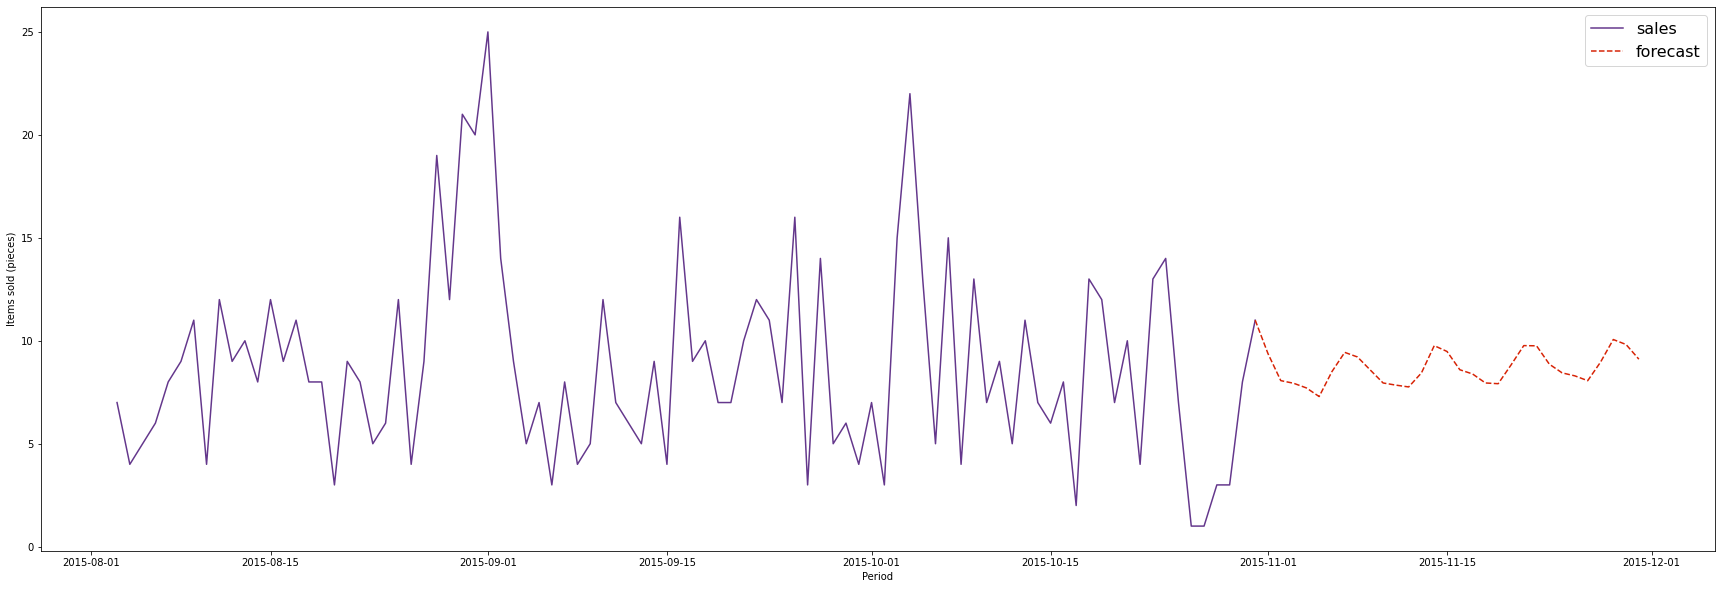

In [29]:
# forecast the values
forecast = results_ARIMA.forecast(30)

# set the last x amount of days to preview
last_x_days = 90

# add the last known value to the forecast to create a continuous line
last_row = df.iloc[-1]
s = pd.Series(last_row[0], index=[last_row.name])
s.rename('predicted_mean', inplace=True)
forecast = s.append(forecast)

# plot the forecast with the known values
plt.plot_date(df.index[-last_x_days:], df['sales'][-last_x_days:], label='sales', fmt="", marker=None, color=iwi_purple)
plt.plot(forecast, label='forecast', linestyle='dashed', color=hka_red)
plt.xlabel(label_period)
plt.ylabel(label_sales_unit)
plt.legend()

del s, last_row, last_x_days